C:\Users\sfska\AppData\Local\Temp\ipykernel_12432\1481258190.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)


Baseline difference 0.0


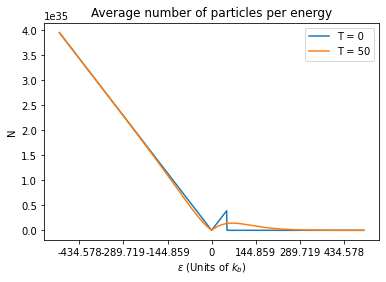

Best mu 17.897112611750337


In [32]:
from matplotlib import ticker
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.integrate as integrate

hbar = 1.05457182e-34
k_b = 1.380649e-23 #m^2 kg/s^2/K
v_f = 1e6
dos_slope = 2/pi/hbar**2/v_f**2

def DOS(x, slope=dos_slope, dirac_point=0):
    return slope*abs(x-dirac_point)


def f(x, mu, T):
    return 1/(np.exp((x-mu)/(k_b*T)) + 1)

def compute_diff(mu1, mu2, temp):
    baseline = lambda x, mu=mu1: f(x,mu, 1e-50) * DOS(x)
    fitted = lambda x, mu=mu2, temp=temp: f(x,mu,temp) * DOS(x)
    N_total = integrate.quad(baseline, -10000*k_b, 10000*k_b)
    N_fitted = integrate.quad(fitted , -10000*k_b, 10000*k_b)
    diff = N_fitted[0]-N_total[0]
    return diff

def optimize_mu(mu1, fitted_temp,threshold = 0.01, max_steps = 1000):
    # prepare our bounds for binary search
    mini = -1 * k_b
    maxi = 1 * k_b
    while compute_diff(mu1, mini, fitted_temp) > 0:
        mini *= 2
    while compute_diff(mu1, maxi, fitted_temp) < 0:
        maxi *= 2

    mu_guess = (maxi+mini)/2
    diff = compute_diff(mu1, mu_guess, fitted_temp)
    steps = 0
    while threshold < abs(maxi-mini)+abs(diff) and steps <= max_steps:
        steps += 1
        mu_guess = (maxi+mini)/2
        diff = compute_diff(mu1, mu_guess, fitted_temp)
        # print("Steps:", steps, "Computed diff", diff)
        if diff > 0:
            maxi = mu_guess
        else:
            mini = mu_guess
    return mu_guess



mu1 = 50 * k_b
mu2 = 17.897112611750337 * k_b

temp = 50
baseline = lambda x, mu=mu1: f(x,mu, 1e-50) * DOS(x)
fitted = lambda x, mu=mu2, temp=temp: f(x,mu,temp) * DOS(x)
N_total = integrate.quad(baseline, -10000*k_b, 10000*k_b)
N_fitted = integrate.quad(fitted, -10000*k_b, 10000*k_b)
print("Baseline difference", N_total[0]-N_fitted[0])

domain = np.linspace(-500*k_b, 500*k_b, 1000)
plt.plot(domain, baseline(domain), label="T = 0")
plt.plot(domain, fitted(domain), label ="T = {}".format(temp))

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/k_b))
plt.gca().xaxis.set_major_formatter(ticks)
plt.xlabel("$\epsilon$ (Units of $k_b$)")
plt.ylabel("N")
plt.title("Average number of particles per energy")
plt.legend()
plt.show()

print("Best mu", optimize_mu(mu1, temp)/k_b)

In [ ]:
from tqdm import tqdm

shifts = np.linspace(-100,100) * k_b
data = []
for mu_0 in tqdm(shifts):
    temps = np.linspace(0,200)
    mus = []
    for temp in temps:
        mus.append(optimize_mu(mu_0, temp) / k_b)
    plt.plot(temps,mus)
    plt.title("Graph for $mu_0$={} * $k_b$".format(mu_0/k_b))
    plt.xlabel("Temp")
    plt.ylabel("fitted mu")
    plt.show()
    data.append((temps,mus)) # will contain a list of tuples which have the temp, mu data
np.save("mu-temp data", data)

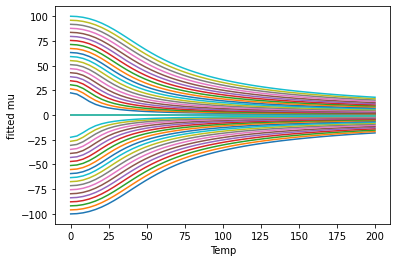

In [44]:
data = np.load("mu-temp data.npy")

for i in np.arange(len(data)):
    temps,mus = data[i]
    plt.plot(temps, mus, label=shifts[i]/k_b)
    # plt.legend()
    plt.xlabel("Temp")
    plt.ylabel("fitted mu")
plt.show()
np.save("mu-temp data", data)